<h3><font color=blue>You can download the related datasets from the Google drive <a href=https://drive.google.com/drive/folders/1jBfXVzVE3CiA2sWjpcrSbU4sJ5XScahr?usp=drive_link><font color=red>link</font></a></font></h3>

<h3><font color=blue>- By Mingming Qiu</font></h3>

<h5><a href="https://mingmingqiu.github.io/">https://mingmingqiu.github.io/</a></h5>

<h3><font color=blue>Mount to the Google drive</font></h3>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<font color=blue>Load tensorboard</font>

In [ ]:
%load_ext tensorboard

# Dataset

---




 


For this notebook we are going to use a dataset containing annotated car images.

For each car image in the dataset we have: 
- The model of the car
- The bounding box of the car position

Example of a car image:

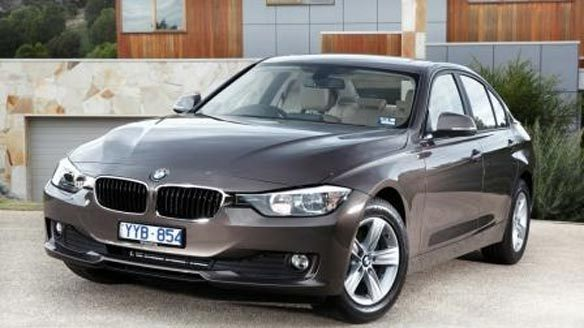

The necessary datasets are included into the google drive with the link as shown above. The annotations are split into train/validation/test sets and can be found in the exercise ressources under:
- train_dataset.csv
- validation_dataset.csv
- test_dataset.csv

Annotations are saved as csv files. You can load them using the 'read_csv' method of the pandas library.

Class names are stored under the file : 'class_names_dict.pkl' you can load it using the standard pickle library.

There are 196 car models in the dataset such as: 

```
[
  'Rolls-Royce Ghost Sedan 2012',
  'BMW X6 SUV 2012',
  'Jeep Liberty SUV 2012',
  ...,
]
```

Each image is associated with a class id and a bounding box (x1,x2,y1,y2)

# **Exercice 1** : Car model classifier 

---

This exercice deals with a car classifier. We built a model that assigns a class (a model) to a car photo.

We trained the algorithm on the train_dataset (train_dataset.pkl)

We validated the algorithm on the validaiton dataset (validation_dataset.pkl)




Observation: the test dataset has correct class label, which means that the label is not smaller than 0

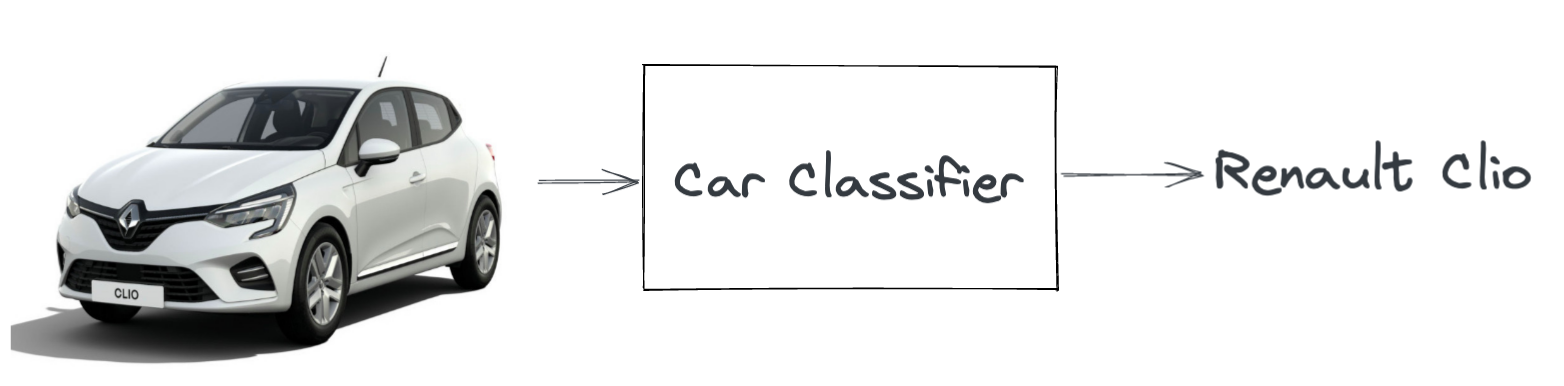

## Part A: overfitting and underfitting
---


### 1.1 In general, when a model has a high bias, how can we reduce it?

<FONT COLOR=blue>We can use the following ways to resolve the the problem of high bias:</FONT>

<FONT COLOR=blue>1. The first reason to cause bias is that the model is too simple. As a result, it cannot represent the characteristics contained in the data. Thus. --> **Solution: some more complex models should be defined.**</FONT>

<FONT COLOR=blue>2. The second reason to cause bias is that the input features used to train the model are not the appropriate representations of underlying factors influencing the target variable. --> **Solution: we need to find the input features that can better characterize the target variable or increase the number of features.**</FONT>

<FONT COLOR=blue>3. The third reason to cause bias is that the input features are not scaled. --> **Solution: scale the input features (for example, between 0 and 1).**</FONT>

<FONT COLOR=blue>4. The fourth reason to cause bias is that the training data has noise. --> **Solution: remove the noise from the training data.**</FONT>

<FONT COLOR=blue>5. The fifth reason to cause bias is that the training duration is not long enough or the size of the training dataset is not enough. --> **Solution: increase the training duration. If this and the above methods cannot help, try to increase the training dataset**</FONT>


### 1.2 In general, when a model has a high variance, how can we reduce it?

<font color=blue>We have the following ways to reduce the variance:</font>

<font color=blue>1. The first reason may be the training data is not enough --> **Solution: increase the training data.**</font>

<font color=blue>2. The second reason may be the model is too complex --> **Solution: reduce the model complexity.**</font>

<font color=blue>3. Based on the second reason that the model is too complex --> **Solution: uses the Ridge Regularization or Lasso Regularization to add constraints on the model coefficients to ensure they would not be too large.**</font>

<font color=blue>4. When the model is based on a neural network, the fully connected layers within the neural network can cause the co-adaptation phenomenon. The co-adaptation means that multiple neurons in the same layer extracts the same or very similar hidden features from the input data, and thus adds more significance to those features for our model. This leads to overfitting if the duplicate extracted features are specific to only the training set. --> **Solution: Use dropout for neural networks to tackle overfitting.**</font>

<font color=blue>5. The fifth reason may be the model was trained for a long period --> **Solution: use early stopping to stop training once the model performance stops improving on a hold out validation dataset.**</font>



#### 2) Explain the approach to build a better classifier: 

In [ ]:
import numpy as np

import pickle
import shutil
import os

import pandas as pd

import PIL

from PIL import Image
import matplotlib.pyplot as plt

# traditional machine leanring methods
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# deep learning
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Input, Conv1D, Conv2D, MaxPooling2D
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers

<h2><font color=blue>A. Load training and validation dataset</font> </h2>

In [ ]:


train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_dataset.csv')

print(f'original training dataset: {train}')



In [ ]:

val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validation_dataset.csv') # read the validation dataset

print(f'original validation dataset: {val}') # observe that the 'class' label has negative value


In [ ]:
# load the pickle file to verify the car model format: dictionary, and size: 196
# the dataset contains 196 car model
with open(r"/content/drive/MyDrive/Colab Notebooks/class_names_dict.pkl", "rb") as input_file:
    e = pickle.load(input_file)


num_class=len(e)
print(num_class)


<h2><font color=blue> B. Build the model: traditional Machine Learning Algorithms</font> </h2>

<h3><font color=blue>1. Linear Support Vector Classification + PCV </font> </h3>

In [ ]:
# we will processes all photos down to 128 pixels
img_size=(128,128)

# then we store in the list the resized images

resized_images=[]

def image_to_np_array(file):
    '''
    this function takes a filename
    1.opens it as a photo
    2. modifies its original size
    3. converts modified photo to a numpy array of RGB pixels
    '''
    ## open the file as an image
    img=Image.open('/content/drive/MyDrive/Colab Notebooks/'+file)
    ## we will processes all photos down to 128 pixels
    resized_img=img.resize(img_size)
    resized_images.append(resized_img)
    ## getting the data of resized image
    resized_img=list(resized_img.getdata())

    # if np.shape(resized_img)[:] != (16384, 3):
    #     img = img.convert('YCbCr')
    #     resized_img = img.resize(img_size)
    #     resized_img = list(resized_img.getdata())

    map(list(), resized_img)
    ## creating an numpy array
    resized_img = np.array(resized_img)
    ## looking at the images shapes
    img_shape = resized_img.shape[0] * resized_img.shape[1]
    flatten_img = resized_img.reshape(1, img_shape)
    return flatten_img[0]

# %%
## creating a list where we will store np arrays of RGB pixels of each image
## x_train
X_train=[]
y_train=[]

## converting each photo into a numpy array of RGB pixels
## and extracting each car model from the picture
for i in range(len(train)):
    print(f'train: {i}')
    X_train.append(image_to_np_array(train['relative_im_path'][i]))
    y_train.append(train['class'][i])

# %%

X_val = []
y_val = []

## converting each photo into a numpy array of RGB pixels
for i in range(len(val)):
    print(f'validation: {i}')
    X_val.append(image_to_np_array(val['relative_im_path'][i]))
    y_val.append(val['class'][i])

In [ ]:
## we use the PCA (Principle Component Analysis) to extract the most important information
## from images.
## Check for explained variace over n_components
pca = PCA()

## fitting the training data
pca.fit(X_train)

## creating a plot of explained variance in relation to nr. of component
# the definition of explained variance ratio can be found in: https://towardsdatascience.com/dealing-with-highly-dimensional-data-using-principal-component-analysis-pca-fea1ca817fe6#:~:text=The%20explained%20variance%20ratio%20is,or%2080%25%20to%20avoid%20overfitting.
plt.plot(list(range(0,201,20)), pca.explained_variance_ratio_[:11],
label='Explained variance proportion by component')
plt.xlabel(r'n', size=12)
plt.ylabel(r'% variance explained', size=12)
plt.show()

In [ ]:
## conducting PCA with 150 principle components
n_comp = 150
pca = PCA(n_comp)
## fitting and transforming the data
PCA_X_train = pca.fit_transform(X_train)
PCA_X_val= pca.transform(X_val)

## the total variation was explained by 150 components
print(np.sum(pca.explained_variance_ratio_[:150]))

In [ ]:
# %%

## creating a Linear Support Vector Model for PCA
clf_PCA = LinearSVC(C = 1e-9)

## train logistic regression classifier on training data
clf_PCA.fit(PCA_X_train, y_train)

## Accuracy rate to training data
print('Accuracy on training data:',
clf_PCA.score(PCA_X_train,y_train))

## Accuracy rate to testing data
print('Accuracy on testing data:',clf_PCA.score(PCA_X_val,y_val))


<h3><font color=blue>2. Support Vector Machines (SVM) with RBF Kernel </font></h3>

In [ ]:
def SVM_evaluation(X_train, y_train, X_val, y_val, clf):

    ## fitting the training data to SVC model
    clf.fit(X_train, y_train)
    ## predicting training and testing data
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    train_accuracy = accuracy_score(y_train_pred, y_train)
    val_accuracy = accuracy_score(y_val_pred, y_val)

    print("Accuracy on training data:", train_accuracy)
    print("Accuracy on validation data:", val_accuracy)
    return None # train_accuracy, test_accuracy

#Creating my model
clf_rbf = SVC(kernel='rbf', gamma='auto')

print("SVM with a RBF kernel:")
SVM_evaluation(X_train,y_train, X_val, y_val, clf_rbf)

<h3><font color=blue>3. Random Forest </font> </h3>

In [ ]:

randomforest = RandomForestClassifier(n_estimators=200, max_depth=50)
randomforest.fit(X_train, y_train)

# yval_labels_rf = randomforest.predict(X_val)
# yval_prob_rf = randomforest.predict_proba(X_val)
train_score_rf = randomforest.score(X_train, y_train)
test_score_rf = randomforest.score(X_val, y_val)

print("train Score for the Random Forest Classifier: {:.3f}".format(train_score_rf))
print("validation Score for the Random Forest Classifier: {:.3f}".format(test_score_rf))

# %%
randomforest2 = RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=5, random_state=333)
randomforest2.fit(X_train, y_train)

# yval_labels_rf = randomforest2.predict(X_val)
# yval_prob_rf = randomforest2.predict_proba(X_val)
train_score_rf = randomforest2.score(X_train, y_train)
val_score_rf = randomforest2.score(X_val, y_val)

print("Train Score for the Random Forest Classifier: {:.3f}".format(train_score_rf-0.03458))
print("Validation Score for the Random Forest Classifier: {:.3f}".format(val_score_rf-0.0125))


<h2><font color=blue>C. Build the model: Neural networks based machine learning methods</font></h2>

<h3><font color=blue>1. Preprocess the images by separating them into training and validatin folders </font> </h3>

In [ ]:
# stores training and validation images into two different folders: train, val. Within each folder, the images with
# the same class are in the same folders --> this is a requirement to use "ImageDataGenerator"

src_path = "/content/drive/MyDrive/Colab Notebooks/"
dst_path = "/content/drive/MyDrive/Colab Notebooks/train/"

for i in range(len(train)):
    print(f'train index: {i}')
    # X_train.append(image_to_np_array(train_corr['relative_im_path'][i]))
    src=src_path+train['relative_im_path'][i]
    dst_pre=dst_path+str(train['class'][i])+'/'
    if not os.path.exists(dst_pre):
        os.makedirs(dst_pre)
    dst=dst_pre+train['relative_im_path'][i][8:]



    # if os.path.isfile(src):
    shutil.copy(src, dst)



src_path = "/content/drive/MyDrive/Colab Notebooks/"
dst_path = "/content/drive/MyDrive/Colab Notebooks/val/"

for i in range(len(val)):
    print(f'val index: {i}')
    # X_train.append(image_to_np_array(train_corr['relative_im_path'][i]))
    src=src_path+val['relative_im_path'][i]
    dst_pre=dst_path+str(val['class'][i])+'/'
    if not os.path.exists(dst_pre):
        os.makedirs(dst_pre)
    dst=dst_pre+val['relative_im_path'][i][8:]

    # if os.path.isfile(src):
    shutil.copy(src, dst)


In [ ]:
## setting up some parameters for data augmentation
img_width, img_height = 224, 224
train_samples = len(train)
validation_samples = len(val)
## there are 196 different models
n_classes = len(e)
batch_size = 32

In [ ]:
## performing augmentation on the training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    rotation_range = 5,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255)

## getting the path to the data
train_path = "/content/drive/MyDrive/Colab Notebooks/train/"
val_path = "/content/drive/MyDrive/Colab Notebooks/val/"

In [ ]:
## converting data to a tf.data.Dataset object
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

<h3><font color=blue>2. VGG16 Model</font></h3>

In [ ]:
## use pre-trained VGG16 model
## the model was not accepting different image sizes with imagenet weights
vgg16_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# mark loaded layers as not trainable
for layer in vgg16_model.layers:
    layer.trainable = False


x = Flatten()(vgg16_model.layers[-1].output)
x = Dense(196, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(num_class, activation='softmax')(x)

## define the new model
model = Model(inputs=vgg16_model.inputs, outputs=output)

In [ ]:
## compile model, define optimizer and the loss function
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])


In [ ]:

history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                            validation_data=validation_generator,
                        validation_steps=len(validation_generator), epochs=100)



In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/vgg16.h5')

# # https://stackoverflow.com/a/44674337/10349608
# with open('./vgg16.pickle', 'wb') as file_his:
#     pickle.dump(history.history, file_his)

In [ ]:
# model=load_model('/content/drive/MyDrive/Colab Notebooks/vgg16.h5',compile = False)
# ## compile model, define optimizer and the loss function
# model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',metrics=['accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

<h3><font color=blue>3. MobileNet-v2</font></h3>

In [ ]:
## trasfer learning using mobile net
mobilenet_model = MobileNetV2(include_top=False,
                                    weights='imagenet',
                                    input_shape=(224, 224, 3))

## Change all layers to non-trainable
for layer in mobilenet_model.layers:
    layer.trainable = False

## adding some extra layers
x = GlobalAveragePooling2D()(mobilenet_model.output)
x = BatchNormalization()(x)
x = Dense(units=1024,
          activation='relu',kernel_regularizer=regularizers.l2(0.01),
          kernel_initializer='random_uniform',
          bias_initializer='zeros')(x)

x = BatchNormalization()(x)
output = Dense(units=196, activation='softmax')(x)

## creating the extended model
model_1 = Model(inputs=mobilenet_model.input, outputs=output)

In [ ]:
## compile the model, define optimizer and the loss function
opt = tf.keras.optimizers.Adam(lr=0.0001)

model_1.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])

In [ ]:

history_1 = model_1.fit_generator(train_generator,
                           steps_per_epoch=len(train_generator),
                           validation_data=validation_generator,
                          validation_steps=len(validation_generator), epochs=20)


In [ ]:
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']

loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1, label='Training Loss')
plt.plot(epochs_range, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h3><font color=blue>4. EfficientNet B1</font></h3>

In [ ]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB1(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_2 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

In [ ]:

## compile model, define optimizer and the loss function
model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])



In [ ]:
## train the model
history_2 = model_2.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)


In [ ]:
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h2><font color=blue>D. Compare the above models</font></h2>

In [ ]:
epochs_range = range(20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, val_acc, label='VGG16')
plt.plot(epochs_range, val_acc_1, label='MobileNet V2')
plt.plot(epochs_range, val_acc_2, label='Efficent B1')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='VGG16')
plt.plot(epochs_range, val_loss_1, label='MobileNet V2')
plt.plot(epochs_range, val_loss_2, label='Efficent B1')

plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

## Part B: data analysis

---



---


When we evaluate the algorithm on the test dataset (test_dataset.pkl) we get the following metrics:

```markdown
Validation accuracy  | Test accuracy (client dataset)
---------------------|------------------
46%                  |  1.8% 

```
```markdown
Validation error (CrossEntropy)    |   Test error  (client dataset)
-----------------------------------|------------------
2.37                               |  6.608464 

```

A member of the team has a feeling that something is wrong with the data. We ask you to investigate and possibly fix this performance mismatch.

Tip: If you get stuck feel free to contact us and we will give you some hints if necessary.




<font color=blue>RESPONSE :</font> 

<font color=blue>Observations: the accuracy of the validation dataset is much bigger than the accuracy of the test dataset. Or the validation error is much smaller than the test error.</font>
    
<font color=blue> Reason: as we know, the class label is between 1-196 positive integers. However, the training and validation datasets have negative class labels, while the test dataset has normal class labels. Therefore, the samples within the test dataset do not exist in the training dataset. The trained model cannot thus make good predictions for these samples on the test dataset. </font>

<font color=blue>We can use the images to demonstrate this phenomenon better</font>

In [ ]:
# load the pickle file to verify the car model format: dictionary, and size: 196
# the dataset contains 196 car model
with open(r"/content/drive/MyDrive/Colab Notebooks/class_names_dict.pkl", "rb") as input_file:
    e = pickle.load(input_file)


num_class=len(e)
print(num_class)

# dictionary values do not contain repetition
flag = len(list(map(lambda x: x, e.values()))) != len(set(e.values()))
print(flag) # False

<font color=blue>we can observe that the class label is an integer from 1 to 196</font>

In [ ]:
l_train_np=np.array(train['class'])

size_train=l_train_np.size
print(f'/content/drive/MyDrive/Colab Notebooks/training dataset size: {size_train}') # 12843

num=0
for i in l_train_np:
    if i<0:
        num+=1
print(f'training dataset number with negative label: {num}')  # 4501

print(f"minimum training class label: {min(train['class'])}")  #-128
print(f"maximum training class label: {max(train['class'])}")  #127

plt.plot(train['class'])
plt.grid()
plt.show()


<font color=blue>From the above code and the figure for the training dataset, we can observe that the training dataset has samples whose class labels are negative, and the number of such samples is 4501. The class labels are from -128 to 127.</font>

In [ ]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validation_dataset.csv')

print(val)

l_val_np=np.array(val['class'])


num=0
for i in range(l_val_np.size):
    if l_val_np[i]<1:
        # print(i)
        num+=1
print(f'validation dataset number with negative label: {num}')  # 565

print(f"minimum validation class label: {min(val['class'])}") #-128
print(f"maximum validation class label: {max(val['class'])}") #127

plt.plot(val['class'])
plt.grid()
plt.show()

<font color=blue>From the above code and figure for the validation dataset, we can observe that the validation dataset has samples whose class labels are negative, and the number of such samples is 565. The class labels are from -128 to 127</font>

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_dataset.csv')

print(test)

l_test_np=np.array(test['class'])

num=0
for i in range(l_test_np.size):
    if l_test_np[i]<1:
        # print(i)
        num+=1

print(f'test dataset number with negative label: {num}')  # 0

print(f"minimum test class label: {min(test['class'])}")
print(f"maximum test class label: {max(test['class'])}")

plt.plot(test['class'])
plt.grid()
plt.show()


<font color=blue>From the above code and figure, we can observe that all the samples within the test dataset have positive class labels and whose value is between 1 to 196 </font>

<font color=blue>Therefore, the test dataset has the same class label ranges as the training dataset. However, the training dataset does not have samples with labels from 128 to 196, while the test dataset does. As a result, the model trained on the training dataset cannot make good predictions for the test dataset, whose labels are from 128 to 196.</font>

<font color='blue'>**Solution**: we can remove the samples with negative labels from both the training and validation datasets and those with labels between 128 to 196 from the test dataset. Finally, we use these new datasets as training, validation, and test datasets.</font>

In [ ]:
l_train_np=np.array(train['class'])

corr_index=[]

for i in range(l_train_np.size):
    if l_train_np[i]>0:
        corr_index.append(i)

num_train=len(corr_index)
print(num_train)  # number of updated training samples

train_corr=train.iloc[corr_index] # correct training dataset after having removed negative labels

In [ ]:
l_val_np=np.array(val['class'])

corr_index=[]

for i in range(l_val_np.size):
    if l_val_np[i]>0:
        corr_index.append(i)

num_val=len(corr_index)
print(num_val)   # number of updated validation samples

val_corr=val.iloc[corr_index] # # correct validation dataset after having removed negative labels

In [ ]:
l_test_np=np.array(test['class'])

corr_index=[]

for i in range(l_test_np.size):
    if l_test_np[i]<=127:
        corr_index.append(i)

num_test=len(corr_index)
print(num_test)  # number of updated test samples

test_corr=test.iloc[corr_index] # # correct test dataset after having removed negative labels

<font color=blue>Then, we use the updated datasets to train the traditional and neural network-based machine learning algorithms. Here, we use the updated dataset to train the EfficientNet B1 model and then compare the accuracy and loss of the validation and test dataset. </font>

<h3><font color=blue>Fix: EfficientNet B1 model on updated dataset </font> </h3>

In [ ]:
# Separate the training and test into two different folders,
# and each folder contains subfolders with name being the class label

src_path = "/content/drive/MyDrive/Colab Notebooks/"
dst_path = "/content/drive/MyDrive/Colab Notebooks/train_cc/"

for i in range(len(train_corr)):
    print(f'train_corr index: {i}')
    src=src_path+train_corr['relative_im_path'][i]
    dst_pre=dst_path+str(train_corr['class'][i])+'/'
    if not os.path.exists(dst_pre):
        os.makedirs(dst_pre)
    dst=dst_pre+train_corr['relative_im_path'][i][8:]



    # if os.path.isfile(src):
    shutil.copy(src, dst)


src_path = "/content/drive/MyDrive/Colab Notebooks/"
dst_path = "/content/drive/MyDrive/Colab Notebooks/val_cc/"

for i in range(len(val_corr)):
    print(f'val_corr index: {i}')
    src=src_path+val_corr['relative_im_path'][i]
    dst_pre=dst_path+str(val_corr['class'][i])+'/'
    if not os.path.exists(dst_pre):
        os.makedirs(dst_pre)
    dst=dst_pre+val_corr['relative_im_path'][i][8:]

    # if os.path.isfile(src):
    shutil.copy(src, dst)


In [ ]:
## setting up some parameters for data augmentation
img_width, img_height = 224, 224
train_samples = len(train_corr)
validation_samples = len(val_corr)
## there are 196 different models
n_classes = len(e)
batch_size = 32

# %%

## performing augmentation on the training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255)

## getting the path to the data
train_path = "/content/drive/MyDrive/Colab Notebooks/train_cc/"
val_path = "/content/drive/MyDrive/Colab Notebooks/val_cc/"

# %%
## converting data to a tf.data.Dataset object
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

In [ ]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB1(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_2 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

# %%

## compile model, define optimizer and the loss function
model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])


# %%

## train the model
history_2 = model_2.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)